# TCC - Analise Exploratória dos Dados (EDA) + Modelo de Referência (Baseline)

## 1. Configuração do ambiente e bibliotecas

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import warnings

# Processamento de Imagem
from PIL import Image
from skimage.filters import sobel
from skimage.color import rgb2gray

# Machine Learning (Baselines)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Configuracoes Visuais
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams["figure.figsize"] = (12, 6)
warnings.filterwarnings("ignore")

# Caminhos e parametros
DATASET_ROOT = "dataset"     
MANIFEST_CSV = "data/manifesto_chips.csv" # Metadados originais
OUTPUT_CSV = "eda_features_full.csv" # Arquivo para salvar as features extraidas
N_JOBS = -1 # Usa todos os nucleos da CPU
CLASSES = ["com_garimpo", "sem_garimpo"]

## 2. Extração de Atributos 

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import sobel
import warnings

# Configurações
warnings.filterwarnings("ignore")
DATASET_ROOT = "dataset"
MANIFEST_CSV = "data/manifesto_chips.csv"
OUTPUT_CSV = "eda_features_full.csv"
CLASSES = ["com_garimpo", "sem_garimpo"]
N_JOBS = -1

# Extrai características visuais básicas da imagem
def calculate_features(img_path, split, label):
    try:
        with Image.open(img_path) as img_pil:
            img_pil = img_pil.convert("RGB")
            img = np.asarray(img_pil).astype(np.float32) / 255.0

        # Medias de cor e brilho
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        exg_mean = np.mean(2 * g - r - b)
        brightness = np.mean(img)
        
        # Textura e bordas
        gray = rgb2gray(img)
        blur_var = np.var(gray)
        edge_energy = np.mean(sobel(gray))
        
        # Identificadores
        filename = os.path.basename(img_path)
        file_stem = os.path.splitext(filename)[0]

        return {
            "file_stem": file_stem,
            "path": img_path,
            "split": split,
            "class": label,
            "brightness": brightness,
            "exg_mean": exg_mean,
            "blur_var": blur_var,
            "edge_energy": edge_energy
        }
    except Exception:
        return None

def process_dataset(root_dir, class_list):
    file_data = []
    print("Mapeando arquivos no diretório...")
    for split in ["train", "test"]:
        for cls in class_list:
            search_path = os.path.join(root_dir, split, cls, "*")
            files = glob.glob(search_path + ".tif") + glob.glob(search_path + ".png") + glob.glob(search_path + ".jpg")
            for f in files:
                file_data.append((f, split, cls))
    
    print(f"Processando {len(file_data)} imagens em paralelo...")
    results = Parallel(n_jobs=N_JOBS)(
        delayed(calculate_features)(f, s, c) for f, s, c in tqdm(file_data)
    )
    return pd.DataFrame([r for r in results if r is not None])

if __name__ == "__main__":
    # Extração
    if os.path.exists(OUTPUT_CSV):
        os.remove(OUTPUT_CSV)
        
    df_features = process_dataset(DATASET_ROOT, CLASSES)
    
    # Merge com metadados
    if os.path.exists(MANIFEST_CSV):
        print("Cruzando com metadados do manifesto...")
        manifest = pd.read_csv(MANIFEST_CSV)
        
        key_col = 'png_path' if 'png_path' in manifest.columns else 'filename'
        if key_col in manifest.columns:
            manifest['file_stem'] = manifest[key_col].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
            
            # Seleciona colunas e faz merge
            cols = ['file_stem', 'overlap_ratio', 'centroid_lat', 'centroid_lon']
            df_final = pd.merge(df_features, manifest[cols], on='file_stem', how='left')
            
            if 'overlap_ratio' in df_final.columns:
                df_final.rename(columns={'overlap_ratio': 'frac_garimpo'}, inplace=True)
            
            df_final['frac_garimpo'].fillna(-1.0, inplace=True)
            
            df_final.to_csv(OUTPUT_CSV, index=False)
            print(f"Arquivo salvo: {OUTPUT_CSV}")
        else:
            print("Coluna chave não encontrada no manifesto.")
    else:
        print("Manifesto não encontrado. Gerando CSV apenas com features visuais.")
        df_features.to_csv(OUTPUT_CSV, index=False)

Mapeando arquivos no diretório...
Processando 111584 imagens em paralelo...


100%|██████████| 111584/111584 [00:12<00:00, 8797.13it/s]


Cruzando com metadados do manifesto...
Arquivo salvo: eda_features_full.csv


## 3. Análise das Faixas de Garimpo

Iniciando análise de distribuição do dataset...
Dados atualizados via manifesto.


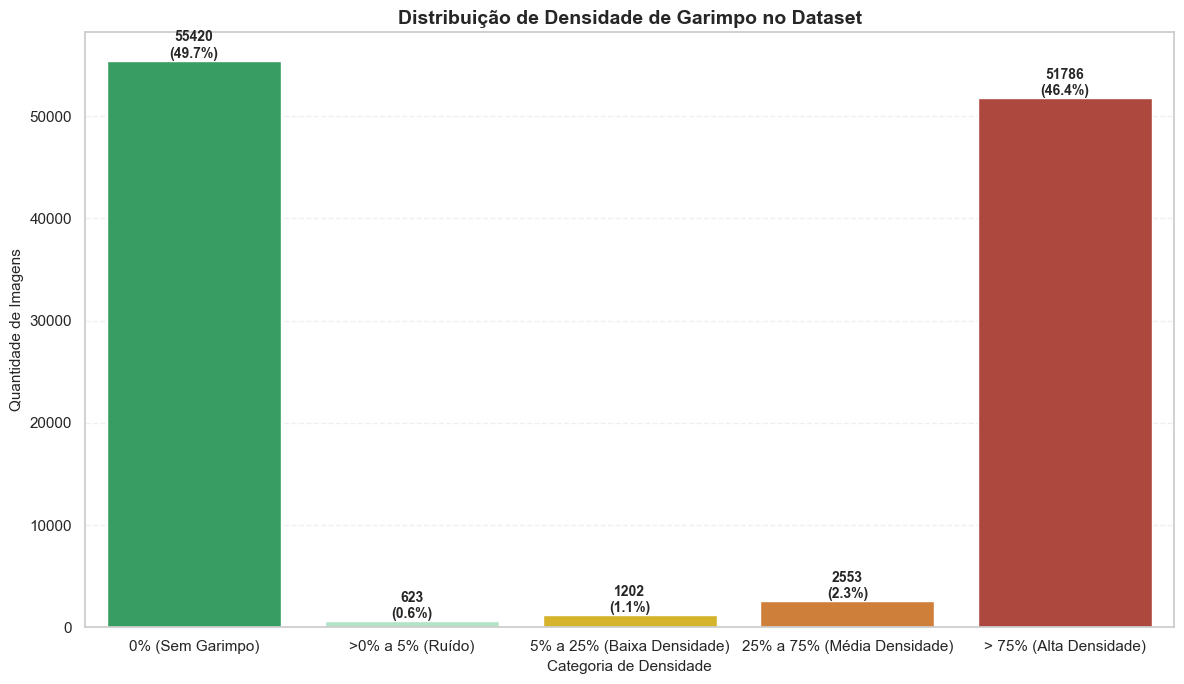


Resumo da distribuição:
density_cat
0% (Sem Garimpo)               55420
>0% a 5% (Ruído)                 623
5% a 25% (Baixa Densidade)      1202
25% a 75% (Média Densidade)     2553
> 75% (Alta Densidade)         51786
Name: count, dtype: int64

Imagens classificadas como ruído: 623


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Configuraçao visual
plt.rcParams["figure.figsize"] = (12, 7)
sns.set_theme(style="whitegrid")

print("Iniciando análise de distribuição do dataset...")

# Recarga de dados para garantir integridade
manifest_path = "data/manifesto_chips.csv"
if os.path.exists(manifest_path):
    manifest = pd.read_csv(manifest_path)
    key_col = 'png_path' if 'png_path' in manifest.columns else 'filename'
    
    manifest['stem_key'] = manifest[key_col].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    map_ratio = dict(zip(manifest['stem_key'], manifest['overlap_ratio']))
    
    df['stem_key'] = df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    df['frac_garimpo'] = df['stem_key'].map(map_ratio).fillna(-1.0)
    print("Dados atualizados via manifesto.")

# Categorizacao
def get_density_category(val):
    if val == -1.0: return "Erro (Sem Info)"
    if val <= 0.00000001: return "0% (Sem Garimpo)"
    if val < 0.05: return ">0% a 5% (Ruído)"
    if val < 0.25: return "5% a 25% (Baixa Densidade)"
    if val < 0.75: return "25% a 75% (Média Densidade)"
    return "> 75% (Alta Densidade)"

df['density_cat'] = df['frac_garimpo'].apply(get_density_category)

# Plotagem
cats_order = [
    "0% (Sem Garimpo)",
    ">0% a 5% (Ruído)", 
    "5% a 25% (Baixa Densidade)", 
    "25% a 75% (Média Densidade)", 
    "> 75% (Alta Densidade)",
    "Erro (Sem Info)"
]
cats_present = [c for c in cats_order if c in df['density_cat'].unique()]

colors = {
    "0% (Sem Garimpo)": "#27ae60",            
    ">0% a 5% (Ruído)": "#abebc6",            
    "5% a 25% (Baixa Densidade)": "#f1c40f",  
    "25% a 75% (Média Densidade)": "#e67e22", 
    "> 75% (Alta Densidade)": "#c0392b",      
    "Erro (Sem Info)": "#000000"
}
palette = [colors[c] for c in cats_present]

plt.figure()
ax = sns.countplot(data=df, x='density_cat', order=cats_present, palette=palette)

plt.title("Distribuição de Densidade de Garimpo no Dataset", fontsize=14, fontweight='bold')
plt.xlabel("Categoria de Densidade", fontsize=11)
plt.ylabel("Quantidade de Imagens", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)

total = len(df)
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        pct = 100 * h / total
        ax.annotate(f'{int(h)}\n({pct:.1f}%)', 
                    (p.get_x() + p.get_width()/2., h), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Resumo numerico
print("\nResumo da distribuição:")
print(df['density_cat'].value_counts().loc[cats_present])

n_noise = len(df[df['density_cat'] == ">0% a 5% (Ruído)"])
print(f"\nImagens classificadas como ruído: {n_noise}")

## 4. Analise Estatistica dos Atributos Visuais

Iniciando analise estatistica de features visuais...


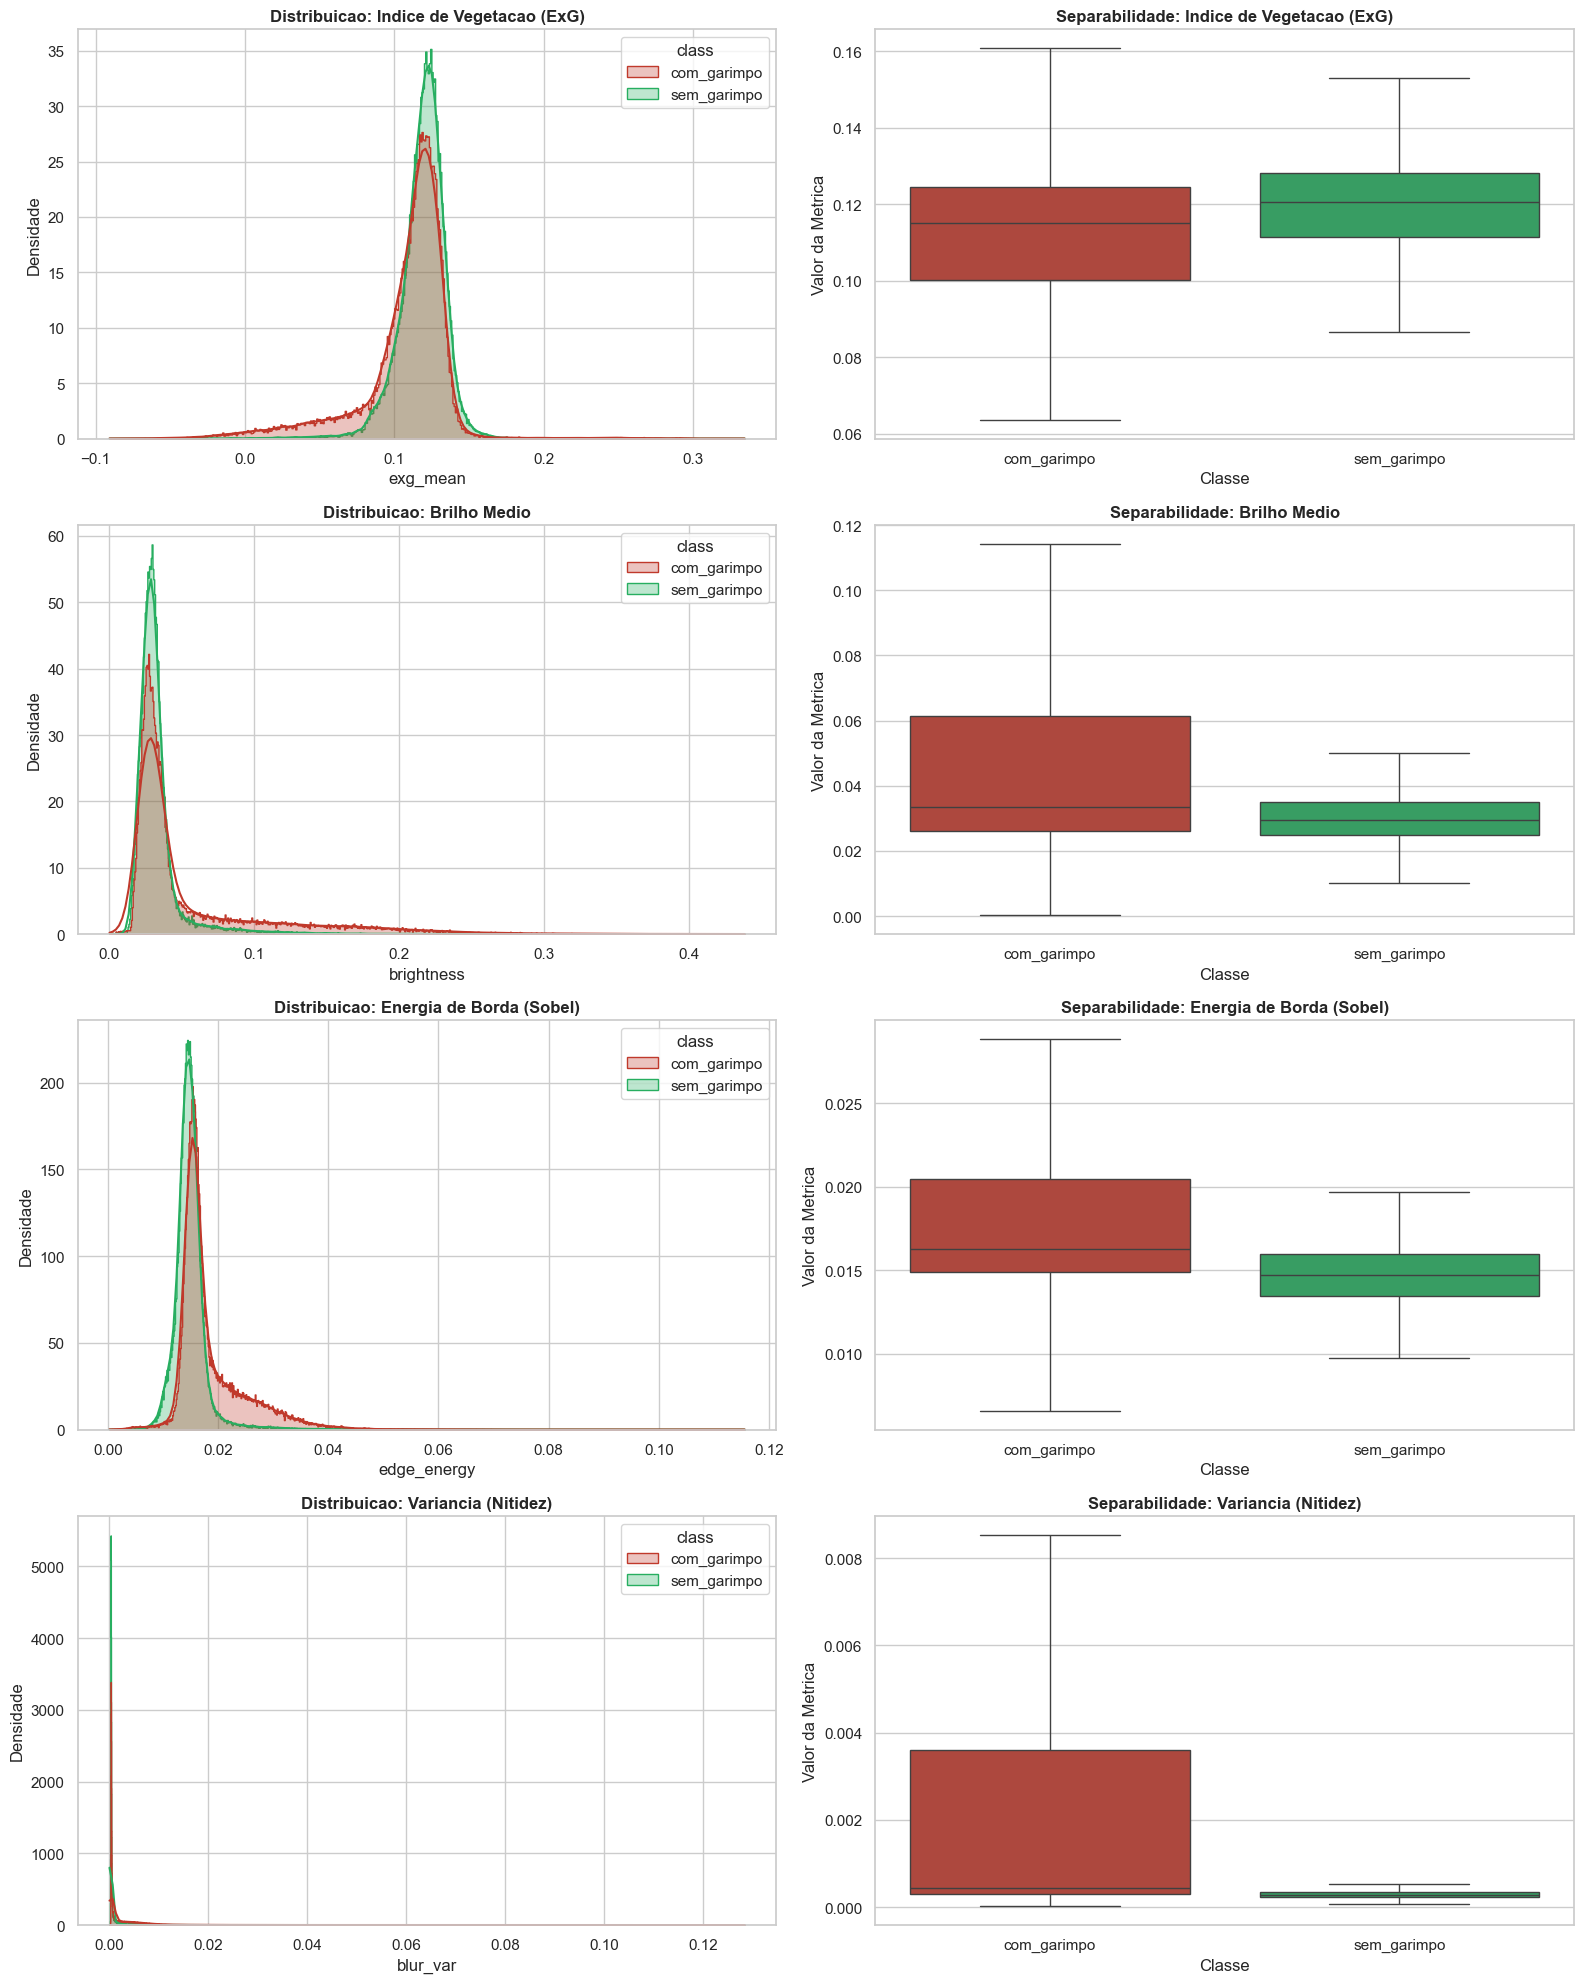


Resumo Estatistico (Media e Desvio Padrao):
            exg_mean         brightness         edge_energy         blur_var  \
                mean     std       mean     std        mean     std     mean   
class                                                                          
com_garimpo   0.1073  0.0315     0.0572  0.0547      0.0187  0.0064   0.0029   
sem_garimpo   0.1186  0.0157     0.0334  0.0193      0.0150  0.0037   0.0007   

                     
                std  
class                
com_garimpo  0.0055  
sem_garimpo  0.0025  

Analise de Separabilidade (Diferenca Relativa entre as Medias):
             Diferenca Percentual (%)
blur_var                   121.410004
brightness                  52.500000
edge_energy                 21.520000
exg_mean                    10.070000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# configuracao visual
plt.rcParams["figure.figsize"] = (16, 12)
sns.set_theme(style="whitegrid")

print("Iniciando analise estatistica de features visuais...")

# definicao das features
features_to_analyze = ['exg_mean', 'brightness', 'edge_energy', 'blur_var']

feature_labels = {
    'exg_mean': 'Indice de Vegetacao (ExG)',
    'brightness': 'Brilho Medio',
    'edge_energy': 'Energia de Borda (Sobel)',
    'blur_var': 'Variancia (Nitidez)'
}

# plotagem
fig, axes = plt.subplots(len(features_to_analyze), 2, figsize=(16, 5 * len(features_to_analyze)))
class_colors = {"sem_garimpo": "#27ae60", "com_garimpo": "#c0392b"}

for i, col in enumerate(features_to_analyze):
    # histograma (densidade)
    sns.histplot(
        data=df, x=col, hue='class', kde=True, element="step", stat="density", 
        common_norm=False, palette=class_colors, ax=axes[i, 0], alpha=0.3
    )
    axes[i, 0].set_title(f"Distribuicao: {feature_labels[col]}", fontweight='bold')
    axes[i, 0].set_ylabel("Densidade")
    
    # boxplot (separacao)
    sns.boxplot(
        data=df, x='class', y=col, palette=class_colors, ax=axes[i, 1], showfliers=False
    )
    axes[i, 1].set_title(f"Separabilidade: {feature_labels[col]}", fontweight='bold')
    axes[i, 1].set_ylabel("Valor da Metrica")
    axes[i, 1].set_xlabel("Classe")

plt.tight_layout()
plt.show()

# resumo estatistico 
print("\nResumo Estatistico (Media e Desvio Padrao):")
group_stats = df.groupby('class')[features_to_analyze].agg(['mean', 'std'])
print(group_stats.round(4))

# calculo de distancia entre as classes (delta)
print("\nAnalise de Separabilidade (Diferenca Relativa entre as Medias):")
means = df.groupby('class')[features_to_analyze].mean()
delta = abs(means.loc['com_garimpo'] - means.loc['sem_garimpo'])
rel_diff = (delta / means.mean()) * 100

# ordena do mais discriminante para o menos discriminante
print(rel_diff.sort_values(ascending=False).to_frame(name="Diferenca Percentual (%)").round(2))

## 5. Baselines com Machine Learning

Iniciando treinamento dos modelos baseline (respeitando divisão train/test das pastas)...
Amostras de Treino: 89266
Amostras de Teste:  22318

Treinando Regressão Logística...
Treinando Random Forest...


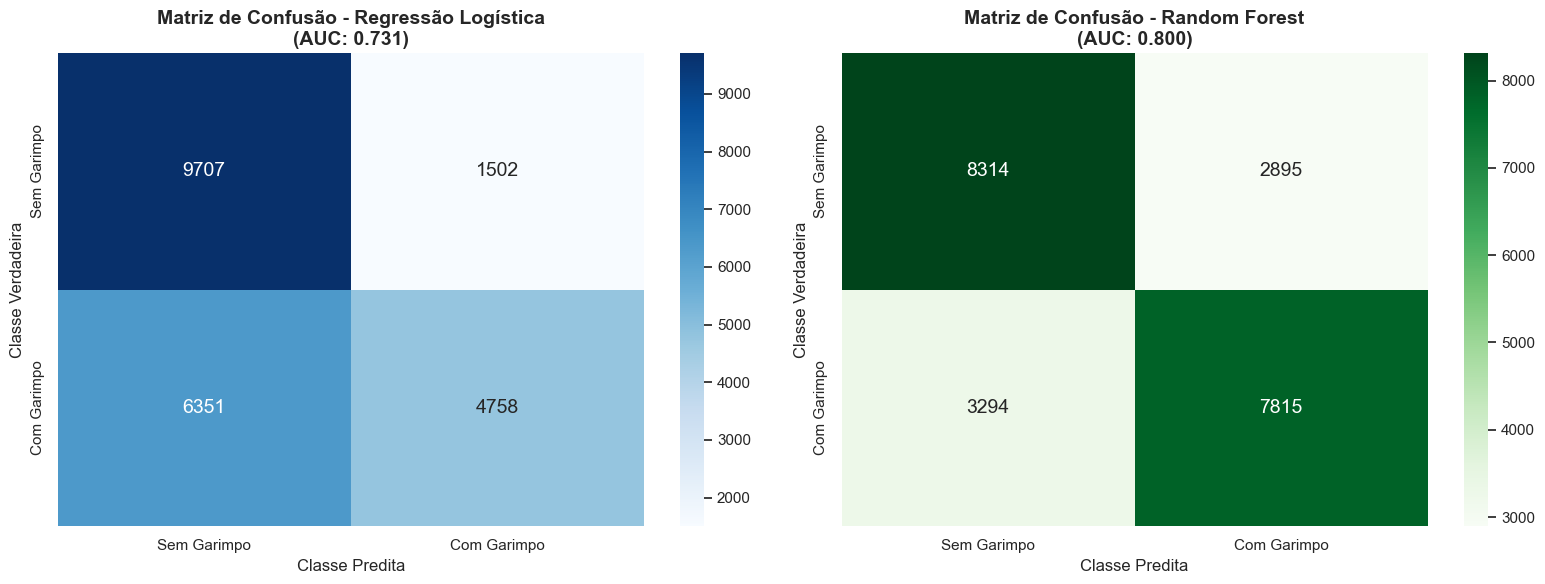

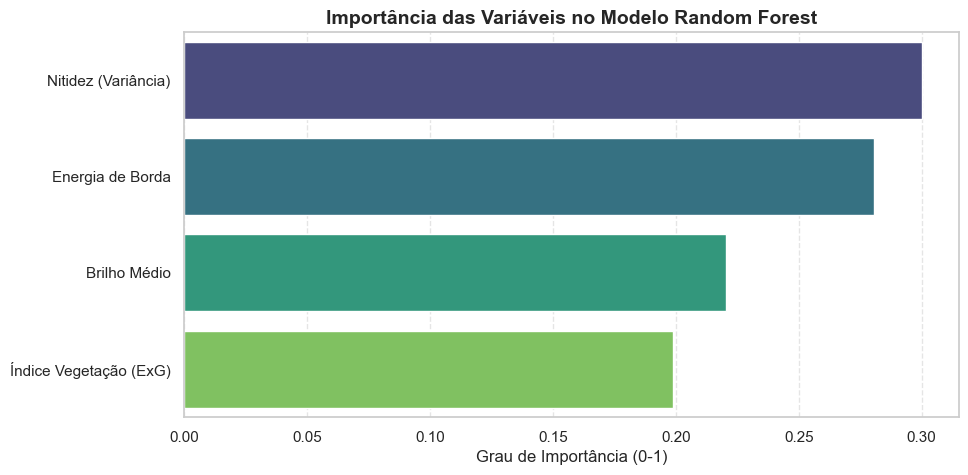


Relatório de Métricas (Teste)
Regressão Logística:
              precision    recall  f1-score   support

 Sem Garimpo       0.60      0.87      0.71     11209
 Com Garimpo       0.76      0.43      0.55     11109

    accuracy                           0.65     22318
   macro avg       0.68      0.65      0.63     22318
weighted avg       0.68      0.65      0.63     22318



Random Forest:
              precision    recall  f1-score   support

 Sem Garimpo       0.72      0.74      0.73     11209
 Com Garimpo       0.73      0.70      0.72     11109

    accuracy                           0.72     22318
   macro avg       0.72      0.72      0.72     22318
weighted avg       0.72      0.72      0.72     22318



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# configuracao visual
plt.rcParams["figure.figsize"] = (14, 6)
sns.set_theme(style="whitegrid")

print("Iniciando treinamento dos modelos baseline (respeitando divisão train/test das pastas)...")

# preparacao dos dados (respeitando a divisao das pastas)
df_clean = df.dropna(subset=['exg_mean', 'brightness', 'edge_energy', 'blur_var']).copy()

# mapeamento de features
feature_map = {
    'exg_mean': 'Índice Vegetação (ExG)',
    'brightness': 'Brilho Médio',
    'edge_energy': 'Energia de Borda',
    'blur_var': 'Nitidez (Variância)'
}

# separar conjuntos
train_mask = df_clean['split'] == 'train'
test_mask = df_clean['split'] == 'test'

X_train = df_clean.loc[train_mask, list(feature_map.keys())]
y_train = df_clean.loc[train_mask, 'target']

X_test = df_clean.loc[test_mask, list(feature_map.keys())]
y_test = df_clean.loc[test_mask, 'target']

print(f"Amostras de Treino: {X_train.shape[0]}")
print(f"Amostras de Teste:  {X_test.shape[0]}")

# normalizacao para regressao logistica
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# treinamento modelo 1: regressao logistica
print("\nTreinando Regressão Logística...")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

# treinamento modelo 2: random forest
print("Treinando Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# visualizacao padronizada
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
class_names = ["Sem Garimpo", "Com Garimpo"]

# funcao auxiliar para plotar matriz de confusao limpa
def plot_cm(y_true, y_pred, title, ax, cmap):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, 
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 14})
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Classe Predita", fontsize=12)
    ax.set_ylabel("Classe Verdadeira", fontsize=12)

# plotar logistica
auc_lr = roc_auc_score(y_test, y_prob_lr)
plot_cm(y_test, y_pred_lr, f"Matriz de Confusão - Regressão Logística\n(AUC: {auc_lr:.3f})", axes[0], 'Blues')

# plotar random forest
auc_rf = roc_auc_score(y_test, y_prob_rf)
plot_cm(y_test, y_pred_rf, f"Matriz de Confusão - Random Forest\n(AUC: {auc_rf:.3f})", axes[1], 'Greens')

plt.tight_layout()
plt.show()

# importancia das variaveis (apenas random forest)
importances = pd.DataFrame({
    'Variavel': [feature_map[c] for c in X_train.columns],
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importances, x='Importancia', y='Variavel', palette='viridis')
plt.title("Importância das Variáveis no Modelo Random Forest", fontsize=14, fontweight='bold')
plt.xlabel("Grau de Importância (0-1)", fontsize=12)
plt.ylabel(None)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# relatorio textual para validacao
print("\nRelatório de Métricas (Teste)")
print("Regressão Logística:")
print(classification_report(y_test, y_pred_lr, target_names=class_names))
print("\n\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

## 6. Curvas de Desempenho dos Modelos de Baseline

Gerando curvas de desempenho comparativas...


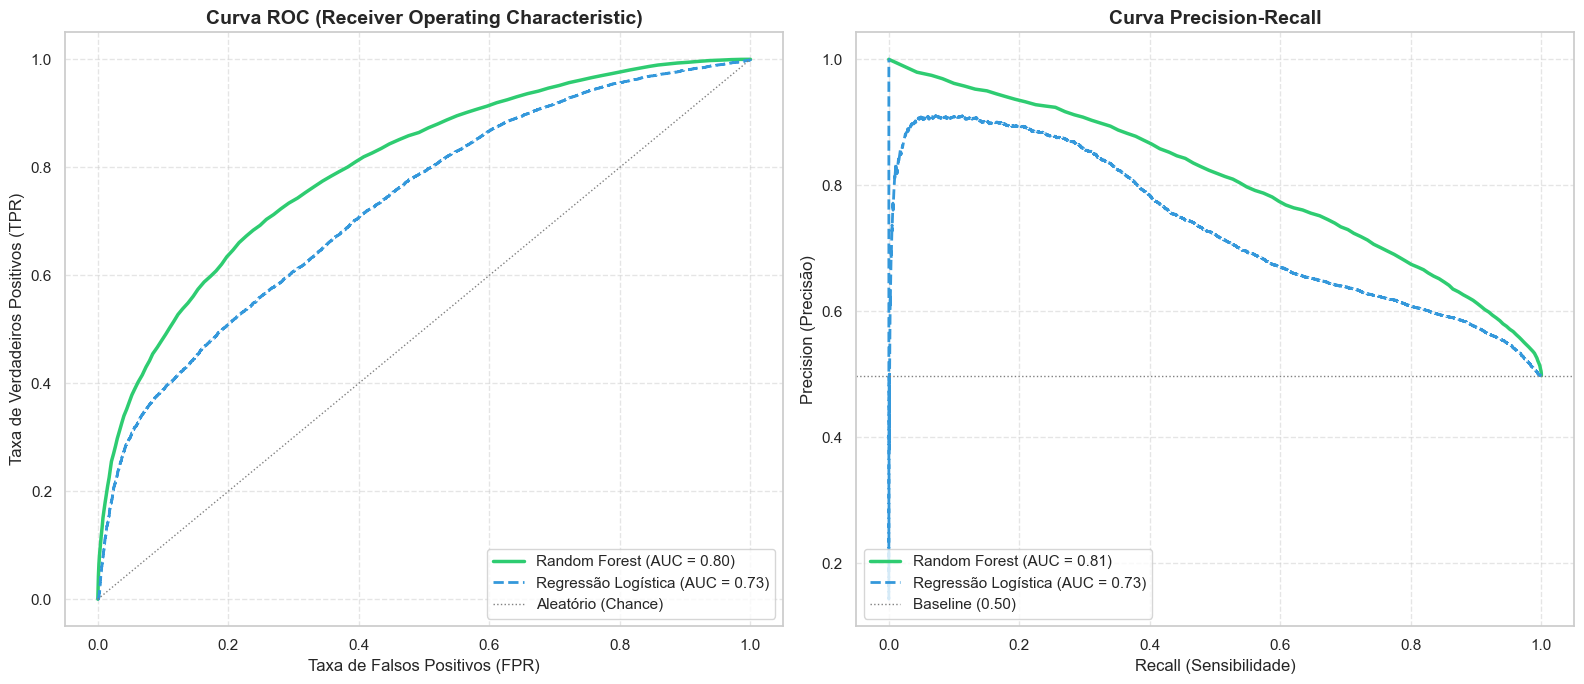

: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# configuracao visual
plt.rcParams["figure.figsize"] = (16, 7)
sns.set_theme(style="whitegrid")

print("Gerando curvas de desempenho comparativas...")

# calculo das curvas roc
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# calculo das curvas precision-recall
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc_lr = auc(rec_lr, prec_lr)

prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = auc(rec_rf, prec_rf)

# plotagem
fig, axes = plt.subplots(1, 2)

# grafico A: curva roc
axes[0].plot(fpr_rf, tpr_rf, color='#2ecc71', lw=2.5, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
axes[0].plot(fpr_lr, tpr_lr, color='#3498db', lw=2, linestyle='--', label=f'Regressão Logística (AUC = {roc_auc_lr:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', label='Aleatório (Chance)')

axes[0].set_title("Curva ROC (Receiver Operating Characteristic)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12)
axes[0].set_ylabel("Taxa de Verdadeiros Positivos (TPR)", fontsize=12)
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(linestyle='--', alpha=0.5)

# grafico B: curva precision-recall
axes[1].plot(rec_rf, prec_rf, color='#2ecc71', lw=2.5, label=f'Random Forest (AUC = {pr_auc_rf:.2f})')
axes[1].plot(rec_lr, prec_lr, color='#3498db', lw=2, linestyle='--', label=f'Regressão Logística (AUC = {pr_auc_lr:.2f})')

# linha de base (proporcao de positivos no teste)
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='gray', lw=1, linestyle=':', label=f'Baseline ({baseline:.2f})')

axes[1].set_title("Curva Precision-Recall", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Recall (Sensibilidade)", fontsize=12)
axes[1].set_ylabel("Precision (Precisão)", fontsize=12)
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()